# Introduction

This is a notebook to see if there is an impact of the socio-demographic variables on the tendency for the subject to get `Right` or `Wrong`. 
It also serves as a recoding and cleaning notebook to obtain a clean dataset that can be reused for other analysis in the future. 


## Import modules and functions

### Modules

In [1]:
# Import modules
import json
import csv
import math

import itertools 
from itertools import combinations

In [2]:
# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans


import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools

import statsmodels.stats as stats 

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

import pingouin as pg

In [4]:
# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

### Functions

In [5]:
# Source: https://github.com/neuhofmo/chisq_test_wrapper


# This module contains functions that wrap the standard chi2_contingency test from scipy.stats.,
# as well as additional corrections for multiple comparisons and post-hoc tests.
# The usage is as simple as chisq_and_posthoc_corrected(df) 

# Uploaded by Moran Neuhof, 2018


def get_asterisks_for_pval(p_val, alpha=0.05):
    """Receives the p-value and returns asterisks string."""
    if p_val > alpha:  # bigger than alpha
        p_text = "ns"
    # following the standards in biological publications
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text  # string of asterisks


def run_chisq_on_combination(df, combinations_tuple):
    """Receives a dataframe and a combinations tuple and returns p-value after performing chisq test."""
    assert len(combinations_tuple) == 2, "Combinations tuple is too long! Should be of size 2."
    new_df = df[(df.index == combinations_tuple[0]) | (df.index == combinations_tuple[1])]
    chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
    return p


def chisq_and_posthoc_corrected(df, correction_method='fdr_bh', alpha=0.05):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction).
    alpha: optional threshold for rejection (default: 0.05)
    correction_method: method used for mutiple comparisons correction. (default: 'fdr_bh').
    See statsmodels.sandbox.stats.multicomp.multipletests for elaboration."""

    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chi2, p))
    
    # post-hoc test
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    print("Post-hoc chi2 tests results:")
    p_vals = [run_chisq_on_combination(df, comb) for comb in all_combinations]  # a list of all p-values
    # the list is in the same order of all_combinations

    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method=correction_method, alpha=alpha)[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print("{}: p_value: {:5f}; corrected: {:5f} ({}) reject: {}".format(comb, p_val, corr_p_val, get_asterisks_for_pval(p_val, alpha), reject))
    return chi2, p, dof, ex


In [6]:
from scipy.stats import chi2_contingency
from scipy.stats import norm
def chisq_posthoc_corrected(cross_table, correction_method='bonferroni', alpha=.05):
    """
    Get crosstab dataframe and do a chisquared test followed with the post-hoc with analysis of adjusted residuals
    source: https://colab.research.google.com/drive/1QIDHMvpDq7Max5hk2mozSFdVssavdV-I#scrollTo=ig1kdg40qLDH
    source: https://github.com/neuhofmo/chisq_test_wrapper
    """
    def get_asterisks_for_pval(p_val, alpha=0.05):
        """Receives the p-value and returns asterisks string."""
        if p_val > alpha:  # bigger than alpha
            p_text = "ns"
        # following the standards in biological publications
        elif p_val < 1e-4:  
            p_text = '****'
        elif p_val < 1e-3:
            p_text = '***'
        elif p_val < 1e-2:
            p_text = '**'
        else:
            p_text = '*'
    
        return p_text  # string of asterisks
    
    chiVal, pVal, df, exp = chi2_contingency(cross_table)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chiVal, pVal))

    colTotals = cross_table.sum()
    nCols = len(colTotals)
    rowTotals = cross_table.sum(axis=1)
    nRows = len(rowTotals)
    n = sum(rowTotals)
    
    
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5            
    phRes = pd.DataFrame(columns=[cross_table.index.name, cross_table.columns.name, 'Adj. Res.'])
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5
            phRes = phRes.append({cross_table.index.name:cross_table.index[i], cross_table.columns.name:cross_table.columns[j], 'Adj. Res.':AdjRes}, ignore_index=True)
    phRes['p_value'] = 2*(1-norm.cdf(abs(phRes['Adj. Res.'])))
    # Bonferroni correction
  
    reject_list, corrected_p_vals = multipletests(phRes['p_value'], method=correction_method, alpha=alpha)[:2]
    
    phRes['p_value_corrected'] = corrected_p_vals
    phRes['reject'] = reject_list
    ast = []
    for p_vals in corrected_p_vals:
        ast.append(get_asterisks_for_pval(p_vals))
    phRes['asterisques'] = ast

    return phRes


# Data

## Loading

In [7]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_filename = 'sondea_analisis_20210323_SONDEA.csv'

In [8]:
df_raw = pd.read_csv('{}{}'.format(data_folder, dataset_filename),  sep=';')

In [9]:
#for col in df_raw.columns:
#    print('{} - Unique var: {}'.format(col, len(df_raw[col].unique())))

#    print(df_raw[col].value_counts().head(8))
#    print('\n')

In [10]:
# convert to datetime columns to type datetime
df_raw['dt_arrive'] = pd.to_datetime(df_raw['date_arrive'])
df_raw['dt_finish'] = pd.to_datetime(df_raw['date_finish'])

# create a new variable to store time completion (in minutes)
df_raw['time_completion_min'] = df_raw.apply(lambda row: round((row['dt_finish'] - row['dt_arrive']).seconds/60,3), axis=1)

#df_raw['dm_lugar'] = df_raw.apply(lambda row: row['dm_provincia'] if row['dm_provincia'] != 'Fuera de España' else unicodedata.normalize('NFD', row['dm_prov_otro'].strip().title()).encode('ascii', 'ignore').decode(), axis=1)
df_raw['dm_lugar_country'] = df_raw.apply(lambda row: row['dm_prov_otro'] if row['dm_provincia'] == 'Fuera de España' else 'España', axis=1)
#TODO [CCAA]

df_raw['dm_employment'] = df_raw.apply(lambda row: row['dm_empleo'] if row['dm_empleo'] != 'Otro' else row['dm_empleo_otro'].strip().title(), axis=1)


## Recoding

### Recode True - Fake news 

We recoded the different option of Fake news and True news and the answers to follow a easier format. Rather than having the answer being dependent to the question to know if it was a correct or no we did as following:

1. Recode the type of news as either `True` new or `Fake` news. 

1. In case of the subject thought a `True` news as `True`, the answer was recoded as `Right`

1. In case of the subject thought a `Fake` news was `Fake`, the answer was recoded as `Right`

1. In case of the subject thought a `True` news was `Fake`, the answer was recoded as `Wrong`

1. In case of the subject thought a `Fake` news was `True`, the answer was recoded as `Wrong`

In [11]:
# Recode the True - False and Fake news
df_raw = df_raw.rename(columns={'tysno_verdadera': 'True news', 'fysno_verdadera': "Fake news"})

# Recode the Si and No into Right and Wrong to avoid confusion
df_raw['True news'] = df_raw['True news'].replace({'sí': 'Right'})
df_raw['True news'] = df_raw['True news'].replace({'no': 'Wrong'})

df_raw['Fake news'] = df_raw['Fake news'].replace({'sí': 'Wrong'})
df_raw['Fake news'] = df_raw['Fake news'].replace({'no': 'Right'})

### Create count_error 

We created a variable called `count_error`. 
We simply check the number of time a subject did a mistake. 
* When the subject got `Right` to all answer, we coded `No error`
* If a subject did a mistake (regardless of considering a Fake news as True, or a True news as Fake), we recoded as `1 error`
* If a subject did 2 mistakes, we recoded as `2 errors`

In [12]:
# Get the number of error per profile
df_raw['count_error_int'] = (df_raw[['True news', 'Fake news']]=="Wrong").sum(axis="columns")
df_raw['count_error'] = df_raw['count_error_int']
df_raw['count_error'].value_counts()

df_raw = df_raw.astype({'count_error': 'category'})
# Transform the count errors into category type
df_raw.count_error.replace({0: 'No error', 1:'1 error', 2:'2 errors'}, inplace=True)



df_raw.count_error = pd.Categorical(df_raw.count_error, categories=['No error', '1 error', '2 errors'],ordered=True)

### Create the 4 categories variables

We created another way to group subjects. 
Here we followed the idea to divide in the 4 possible scenario

1. The subject got the `True` news `Right` and the `Fake` news `Right`: `TR-FR`

1. The subject got the `True` news `Right` and the `Fake` news `Wrong`: `TR-FW`

1. The subject got the `True` news `Wrong` and the `Fake` news `Right`: `TW-FR`

1. The subject got the `True` news `Wrong` and the `Fake` news `Wrong`: `TW-FW`

In [13]:
conditions = [
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Wrong'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Wrong'),
    ]

# create a list of the values we want to assign for each condition
values = ['TR-FR', 'TR-FW', 'TW-FR', 'TW-FW']
df_raw['cat_tf_rw'] = np.select(conditions, values)

In [14]:
df_raw['cat_tf_rw'].value_counts().to_frame()

,cat_tf_rw
TR-FR,447
TR-FW,267
TW-FR,232
TW-FW,117


### Create the 2 categories

Here, created a category with only the `Right` and `Wrong` distinction

In [15]:
df_raw['R-W'] = np.where(
    (df_raw['count_error_int'] > 0), 'W', 'R')

In [16]:
df_raw['R-W'].value_counts().to_frame()

,R-W
W,616
R,447


### Recode religion

We decided to recode the religion into a dichotomic variable. The logic behind is that there were a lot of of `Católico` (n=512), `Ateo` (n=237) and `Agnóstico` (n=164), while other religions where low in number (n<10) (see the table under). 
We could do it different and keep the following coding as alternative (not done here) but it is a sensitive decision.

* `Católico`

* `Ateo`

* `Agnóstico`

* `Other faiths` 

In [17]:
# Recode religion into believers, atheist, agnostic

## Get the value of Otro in dm_pref_religion
df_raw['dm_pref_religion'] = df_raw.apply(lambda row: row['dm_religion'] if row['dm_religion'] != 'Otro' else row['dm_rel_otro'].strip().title(), axis=1)


## Recode the different entries into believers-atheist/agnostics
believers = ['Católico', 'Islámico', 'Evangélico', 'Protestante', 'Budista', 'Cristiano', 'Protestante', 
             'Musulmán', 'Grigoriano Apostolico', 'Soy Cristiana', 'Católica No Practicante', 'Testigo De Jehová', 
             'Católico Pero No Acudo A Misa', 'Soy Cristiano, Creo En Dios', 'Católico No Practicante',
             'Es Largo De Explicar , Es Una Iglesia Moderna', 'Creo En Las Ciencias Ocultas Y La Espiritualidad',
             'Creo En Dios A Través De Jesucristo',
             'Sincretismo Pragmático', 'Creo En Dios A Través De Jesucristo.', 'Ortodoxo']

non_believer_atheist = ['Agnóstico', 'Soy Agnóstico', 'Ateo', 'Ningún Punto Religioso..Creo En La Vida.', 'Ni Creo Ni Dejo De Creer' ]

df_raw['recode_religion'] = df_raw['dm_pref_religion'].replace(believers, 'Believers')
df_raw['recode_religion'] = df_raw['recode_religion'].replace(non_believer_atheist, 'Atheists/Agnostics')
# Code as None if not within these two categories
df_raw['recode_religion'] = np.where(df_raw['recode_religion'].isin(['Believers','Atheists/Agnostics']), df_raw['recode_religion'], None)

In [18]:
df_raw['dm_pref_religion'].value_counts().to_frame()

,dm_pref_religion
Católico,512
Ateo,237
Agnóstico,164
NS/NC,91
Islámico,10
-,9
Evangélico,8
Budista,4
Cristiano,4
Protestante,4


After recoding, we obtained the following repartition between `Believers` and `Atheists/Agnostics`

In [19]:
df_raw['recode_religion'].value_counts().to_frame()

,recode_religion
Believers,555
Atheists/Agnostics,404


### Recode politics

This variable has been recoded into `Izquierda`, `Centro`, `Derecha`, from the original question. 
The recoding is not necessarily needed. Again we can decide to change that later. 

* `Izquierda`: 'Izquierda', 'Centro izquierda'

* `Centro`: 'Centro'

* `Derecha`: 'Derecha', 'Centro derecha'

In [20]:
df_raw['dm_politica'].value_counts().to_frame()

,dm_politica
Izquierda,262
NS/NC,220
Centro izquierda,180
Centro,180
Centro derecha,124
Derecha,84
-,13


In [21]:
# aggregate politics preferences into bigger groups (izquierda, derecha, centro)
def aggregate_politics(val):
    if val in ['Izquierda', 'Centro izquierda']:
        return 'Izquierda'
    elif val in ['Derecha', 'Centro derecha']:
        return 'Derecha'
    elif val == 'Centro':
        return val
    else:
        return None
df_raw['recode_politics'] = df_raw['dm_politica'].apply(aggregate_politics)

After recoding, we obtained the following repartition

In [22]:
df_raw['recode_politics'].value_counts().to_frame()

,recode_politics
Izquierda,442
Derecha,208
Centro,180


### Recode age

Age as been recoded to group in 3 categories:

* `<=18-34`: '< 18 años', '18-24 años', '25-34 años'

* `35-54`: '35-44 años', '45-54 años'

* `>55`: '55-65 años', '> 65 años'

In [23]:
# aggregate ages into bigger groups (18-34, 35-54, >54)
def aggregate_age(val):
    if val in ['< 18 años', '18-24 años', '25-34 años']:
        return '<=18-34'
    elif val in ['35-44 años', '45-54 años']:
        return '35-54'
    elif val in ['55-65 años', '> 65 años']:
        return '>55'
    elif val is None:
        return None
df_raw['recode_age'] = df_raw.dm_edad.apply(aggregate_age)

df_raw.recode_age = pd.Categorical(df_raw.recode_age, categories=['<=18-34', '35-54', '>55'],ordered=True)


df_raw.recode_age.value_counts().to_frame()

,recode_age
35-54,549
<=18-34,258
>55,256


### Recode education

Education has been recoded in two forms. One  is to group the subject into `Uni` vs `No Uni`. While the distinction makes sense regarding the data, it has been considered too *university-self-centerred*. Therefore we fall back on a three categories distinctions

* `up_to_secondaria`: 'Primaria', 'Secundaria', 'No tiene estudios en educación formal'

* `up_to_bac_3`: 'Formación Profesional', 'Bachillerato', 'Cou'

* `up_to_uni`: 'Master','Posgrado', 'Doctorado',  'Grado/Licenciatura'

In [24]:
# Recode education
df_raw['dm_education'] = df_raw.apply(lambda row: row['dm_educacion'] if row['dm_educacion'] != 'Otro' else row['dm_edu_otro'].strip().title(), axis=1)


#education_recoded_values = ['Primaria', 'Secundaria', 'Formación Profesional', 'Grado/Licenciatura', 'Master', 'Posgrado', 'Doctorado' ]

# Code as None if not within the list of education level
#df_raw['recode_education'] = np.where(df_raw['dm_education'].isin(education_recoded_values), df_raw['dm_education'], None)


# Recode education into broader categories
uni = ['Posgrado', 'Doctorado', 'Master', 'Grado/Licenciatura' ]
non_uni = ['No tiene estudios en educación formal', 'Formación Profesional', 'Primaria', 'Secundaria', 'Cou', 'Bachillerato']




df_raw['recode_education'] = df_raw['dm_education'].replace(uni, 'University studies')
df_raw['recode_education'] = df_raw['recode_education'].replace(non_uni, 'No university studies')



# Alternative recoding
up_to_secondaria = ['Primaria', 'Secundaria', 'No tiene estudios en educación formal']
up_to_bac_3 = ['Formación Profesional', 'Bachillerato', 'Cou']
up_to_university_level = ['Master','Posgrado', 'Doctorado',  'Grado/Licenciatura']


# Code as None if not within these categories
df_raw['recode_education'] = np.where(df_raw['recode_education'].isin(['University studies', 'No university studies']), df_raw['recode_education'], None)
df_raw.recode_education.value_counts()

df_raw['recode_education2'] = df_raw['dm_education'].replace(up_to_secondaria, 'up_to_secondaria')
df_raw['recode_education2'] = df_raw['recode_education2'].replace(up_to_bac_3, 'up_to_bac_3')
df_raw['recode_education2'] = df_raw['recode_education2'].replace(up_to_university_level, 'up_to_university_level')
df_raw.recode_education2.value_counts().to_frame()

,recode_education2
up_to_university_level,559
up_to_bac_3,307
up_to_secondaria,195
NS/NC,2


### Recode actions


In [25]:
# faf and taf are questions asked if the subject answer 'True' to the news in case of True and Fake news. 
# The faf will then for people who were wrong and the taf for people who were rignt
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t
df_raw.loc[:, var_actions] = df_raw.loc[:, var_actions].replace({'checked': True, 'unchecked': False})


There is an issue with some subjects answering the no_action while answering other types of action at the same time


In [26]:
# There is an issue with some subjects answering the no_action while answering other types of action at the same time
df_raw['total_checked_f'] = df_raw.loc[:, var_actions_f].isin([True]).sum(axis=1)
df_raw['total_checked_t'] = df_raw.loc[:, var_actions_t].isin([True]).sum(axis=1)

In [27]:
# Drop the subjects when conflicting answer in case of analysing actions. 
df_raw[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True)][['total_checked_f', *var_actions_f]]

,total_checked_f,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion
92,2,False,False,False,True,True
94,2,False,False,True,False,True
97,2,False,False,True,False,True
259,2,False,False,True,False,True
344,2,False,False,True,False,True
534,2,False,False,True,False,True
588,2,False,False,True,False,True
670,2,False,False,True,False,True
673,2,False,False,True,False,True
742,2,False,False,False,True,True


In [28]:
# Drop the subjects when conflicting answer in case of analysing actions. 

for x in var_actions_f:
    df_raw.loc[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True), x] = np.NaN

In [29]:
df_raw[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True)][['total_checked_t', *var_actions_t]]

,total_checked_t,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
79,2,False,False,True,False,True
94,2,False,False,True,False,True
238,2,False,False,False,True,True
327,3,False,False,True,True,True
332,2,False,False,False,True,True
367,2,False,False,False,True,True
394,2,True,False,False,False,True
450,3,False,False,True,True,True
508,2,False,False,True,False,True
516,2,False,False,False,True,True


In [30]:
# Drop the subjects when conflicting answer in case of analysing actions. 

for x in var_actions_t:
    df_raw.loc[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True), x] = np.NaN

### Recode justifications


In [31]:
# In case the subject thinks it is a True News (regardless of the news)
var_justifications_True = ['tys_recuerda_leida',
'tys_medio_comunicacion_conocido',
'tys_medio_comunicacion_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

# In case the subject thinks it is a Fake News (regardless of the news)
var_justification_Wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

### Recode NS/NC into Np.NaN
It seems the NS/NC is equal to `no answer`. We recoded globally accordingly. The consequence in all further analysis is that people who did not answer the question will be removed from the analysis. They are removed for the analysis they did not provide an answer, not removed from the dataset (therefore we will have different N).

In [32]:
# Replace the NS/NC as np.nan to exclude subject in analysis
df_raw = df_raw.replace('NS/NC', np.nan)

## Filtering

### On survey completion

To decide which data are considered as completed, the time to reach `time_news2` is use and it is 

In [33]:
# #FIXME The date_finish is never None. Therefore that datapoint is not relevant. 
fin = ~df_raw['date_finish'].isnull() # finished experiments
ini = df_raw['time_index']>0          # initiated or read news 1
read_only_1 = ini & (df_raw['time_news1']==0) # read only 1 news
read_both = df_raw['time_news1']>0    # read both news
got_to_ans = df_raw['time_news2']>0    # read both news and got to ans

In [34]:
# Filtering
df_all = df_raw
df_init = df_raw[ini]
df = df_raw[got_to_ans]

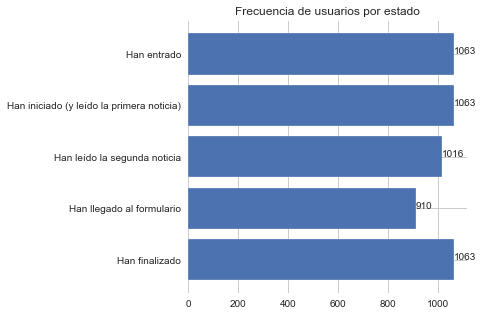

In [35]:
y = ['Han entrado','Han iniciado (y leído la primera noticia)','Han leído la segunda noticia', 'Han llegado al formulario', 'Han finalizado']
x = [df_all.shape[0], df_all[ini].shape[0], df_all[read_both].shape[0], df_all[got_to_ans].shape[0], df_all[fin].shape[0]]
plt.barh(y, x)
for index, value in enumerate(y):
    plt.text(x[index], index, str(x[index]))

plt.gca().invert_yaxis()
plt.title('Frecuencia de usuarios por estado')
plt.show()

The column `Han finalizado` is inconsistent with the other counts. After inspection it is because there is no `None` value for that variable.

In [36]:
df = df_raw[got_to_ans]

print('Size of the filtered sample: {}'.format(df.shape[0]))

Size of the filtered sample: 910


### On time completion

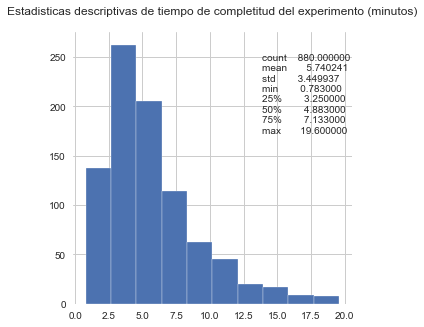

In [37]:
# df[df['time_completion_min']<=20]['time_completion_min'].plot.hist()
fig, ax = plt.subplots()
ax.hist(df[df['time_completion_min']<=20]['time_completion_min'])
plt.figtext(0.65,0.6, df[df['time_completion_min']<=20]['time_completion_min'].describe().to_string())
plt.title("Estadisticas descriptivas de tiempo de completitud del experimento (minutos)\n")
plt.show()

After looking at the data for the time completion, we decided to remove any subject that took less than 2 minutes to answer the survey. 

In [38]:
# Removing the subjects that answer in less or equal to 1 minutes to be sure we get subject that get focused. 
df[df['time_completion_min'] < 2]['time_completion_min'].count()

51

## Final dataset

In [39]:
df = df[df['time_completion_min'] > 2]
print('Size of the final filtered sample: {}'.format(df.shape[0]))

Size of the final filtered sample: 859


# Analysis

## Difference in getting wrong for True News and Fake News

### Data 

In [40]:
true_fake_r_w = df[['True news', 'Fake news']].unstack().reset_index().drop(columns=['level_1'])
true_fake_r_w.columns = ['Type of news', 'Answer']
true_fake_r_w_cont = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'])
true_fake_r_w_cont

Answer,Right,Wrong
Type of news,,
Fake news,550,309
True news,583,276


### Heatmap

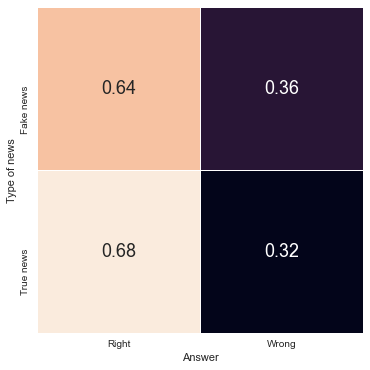

In [41]:
# Create the normalised version for the heatmap
true_fake_r_w_cont_normalised = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'], normalize='index')
true_fake_r_w_cont_normalised

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(true_fake_r_w_cont_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [42]:
data_bar_plot = true_fake_r_w.value_counts().to_frame().rename(columns={0:'count'}).reset_index()

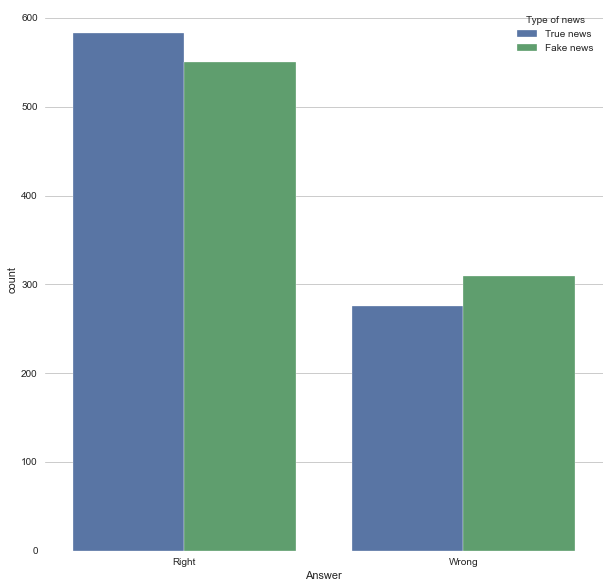

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(hue="Type of news", y="count", x="Answer",  data=data_bar_plot, ax=ax)
plt.show()

### Chi-Square

In [44]:
data_chi_square = chisq_and_posthoc_corrected(true_fake_r_w_cont)

Chi2 result of the contingency table: 2.6542225843196716, p-value: 0.10327523703986423

Post-hoc chi2 tests results:
('Fake news', 'True news'): p_value: 0.103275; corrected: 0.103275 (ns) reject: False


There is no difference in the two groups. It means the subject were not more likely to get right or wrong in case of a Fake news or a True news

## Number of people per number of mistakes

In [45]:
data = df['count_error'].value_counts().to_frame().reset_index()
#data['index'] = pd.Categorical(data['index'], categories=['No error', '1 error', '2 errors'],ordered=True)
data = data.sort_values(by=['index', 'count_error'])
data['count_expected'] = [0.25*data.sum().values[0], 0.5*data.sum().values[0], 0.25*data.sum().values[0]]

### Barplot

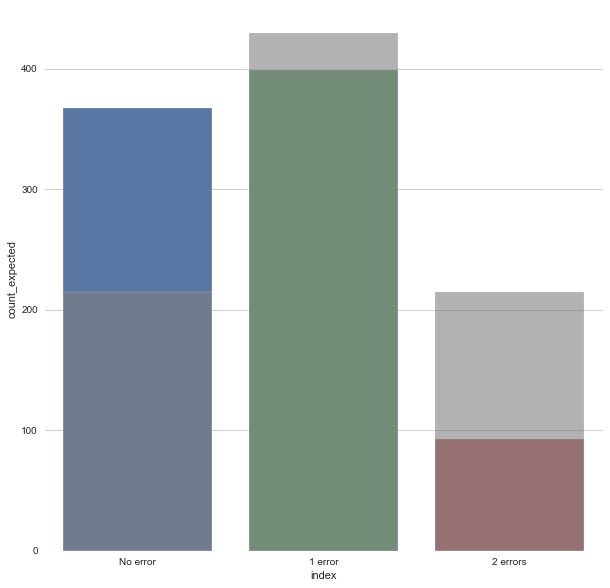

In [46]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot( y="count_error", x="index",  data=data, ax=ax, alpha=1)
sns.barplot( y="count_expected", x="index",  data=data, ax=ax, alpha=0.6, color='grey')
plt.show()

### Goodness of fit

In [47]:
# TODO analysis of where

In [48]:
stats.gof.chisquare(f_obs= data['count_error'], f_exp=data['count_expected'], return_basic=False)

(179.1303841676368, 1.2657015367292102e-39)

The distribution of the sample is different than the expected distribution. It means we have less people than expected that did two errors, while there is more people than expected that did no errors

# Independence

The analysis about the different socio-demographic questions and their link with getting right or wrong to the different news are splitted into three majors sections. 
The first one is when we consider the different groups as separated into three categories (0 errors, 1 errors, 2 errors), the second one is when we consider the different groups separated by the 4 categories ( TR-FR, TR-FW, TW-FR, TW-FW), and ultimately the one on the two categories (R-W). 

Here we output a summary of all the tests ran with the different type of distinctions in the errors. To see the details of the analysis alongside the plots and the post-hoc tests, go to the annexes. 

In [49]:
dep_variables = {'R-W': 'chisquare', 'count_error': 'kruskal', 'cat_tf_rw': 'chisquare'}

ind_variables = {'age': 'recode_age', 
                 'gender': 'dm_genero', 
                 'uni-notuni': 'recode_education', 
                 'edu_levels': 'recode_education2',
                 'politics': 'recode_politics', 
                 'religious_belief': 'recode_religion',
                 'technological_knowledge': 'dm_tecnologia'}
list_results = []
for dv in dep_variables:
    method = dep_variables[dv]
    for iv_name in ind_variables:
        iv_col = ind_variables[iv_name]
        data = df[[iv_col, dv]]
        # Drop the na
        data = data.dropna()
        n_ = len(data)

        data_count = pd.crosstab(data[iv_col], data[dv])
        
        if method == 'kruskal':
            value_per_grp = data.groupby(iv_col)['count_error'].apply(list)
            stats, p_value = scipy.stats.kruskal(*value_per_grp)
            asterisks = get_asterisks_for_pval(p_value)
            
        elif method == 'chisquare':
            
            stat, p_value, dof, ex = chi2_contingency(data_count, correction=True)
            asterisks = get_asterisks_for_pval(p_value)
        result = {'Dep variable': dv, 'Ind variable': iv_name, 'Ind column': iv_col, 'N': n_, 'method': method, 'stat': stat, 'p_value': p_value, 'Sign.': asterisks}
        list_results.append(result)

        

In [50]:
pd.DataFrame(list_results)

,Dep variable,Ind variable,Ind column,N,method,stat,p_value,Sign.
0,R-W,age,recode_age,859,chisquare,0.049936,0.975341,ns
1,R-W,gender,dm_genero,859,chisquare,1.789204,0.181023,ns
2,R-W,uni-notuni,recode_education,858,chisquare,11.291120,0.000779,***
3,R-W,edu_levels,recode_education2,858,chisquare,12.605829,0.001831,**
4,R-W,politics,recode_politics,665,chisquare,10.695501,0.004759,**
5,R-W,religious_belief,recode_religion,772,chisquare,16.240164,0.000056,****
6,R-W,technological_knowledge,dm_tecnologia,856,chisquare,8.791611,0.012329,*
7,count_error,age,recode_age,859,kruskal,8.791611,0.810437,ns
8,count_error,gender,dm_genero,859,kruskal,8.791611,0.251450,ns
9,count_error,uni-notuni,recode_education,858,kruskal,8.791611,0.000956,***


The significative tests are given by the p_values and considered as significative if p < .05. The Sign. column indicate the level of significance. 
The different tests have a post-hoc analysis. In case of Kruskall wallis, the variable is ordinal, therefore the interpretation takes into account the *increase in error".
In case of the chi-square, it is an independent test and the interpretation is in terms of difference in the two groups. The analysis of the Adjusted residuals gives information in which group it is significatif and in which direction. 

# Annexes

## Difference for being better informed with the age

In [51]:
col_var = 'recode_age'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_age,,,
<=18-34,89,94,23
35-54,184,195,51
>55,94,110,19


In [52]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 859


In [53]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_age,,,
<=18-34,0.432039,0.456311,0.111650
35-54,0.427907,0.453488,0.118605
>55,0.421525,0.493274,0.085202


### Heatmap

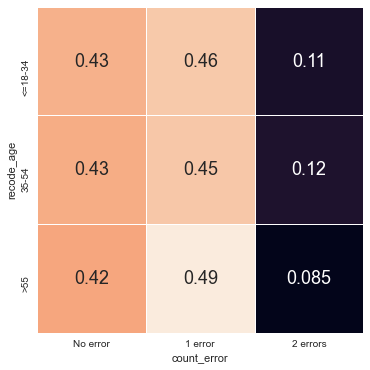

In [54]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [55]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,count_error,count
0,35-54,1 error,195
1,35-54,No error,184
2,>55,1 error,110
3,<=18-34,1 error,94
4,>55,No error,94
5,<=18-34,No error,89
6,35-54,2 errors,51
7,<=18-34,2 errors,23
8,>55,2 errors,19


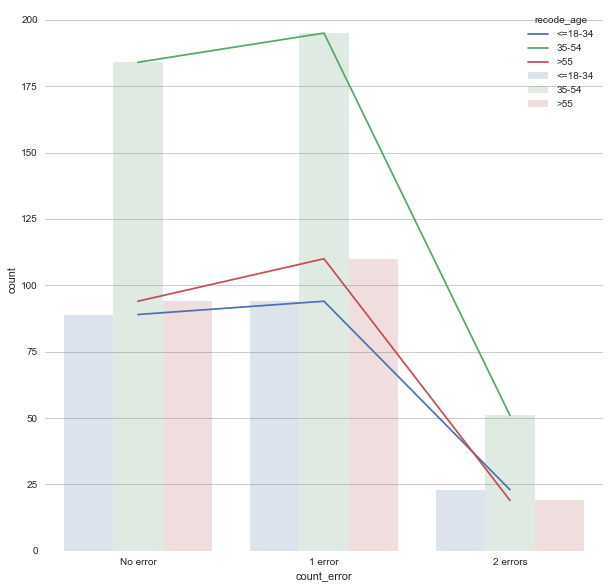

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [57]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [58]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=0.4203637268658092, pvalue=0.8104368437405006)

### Post-hoc: Dunn test

In [59]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,<=18-34,35-54,>55
<=18-34,1.0,1.0,1.0
35-54,1.0,1.0,1.0
>55,1.0,1.0,1.0


There is no difference due to age in getting more or less errors

## Difference due to gender

In [60]:
col_var = 'dm_genero'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,205,206,45
Masculino,162,193,48


In [61]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 859


In [62]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,0.449561,0.451754,0.098684
Masculino,0.401985,0.478908,0.119107


### Heatmap

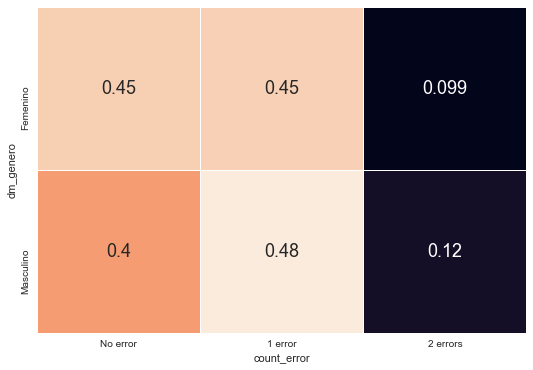

In [63]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [64]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,count_error,count
0,Femenino,1 error,206
1,Femenino,No error,205
2,Masculino,1 error,193
3,Masculino,No error,162
4,Masculino,2 errors,48
5,Femenino,2 errors,45


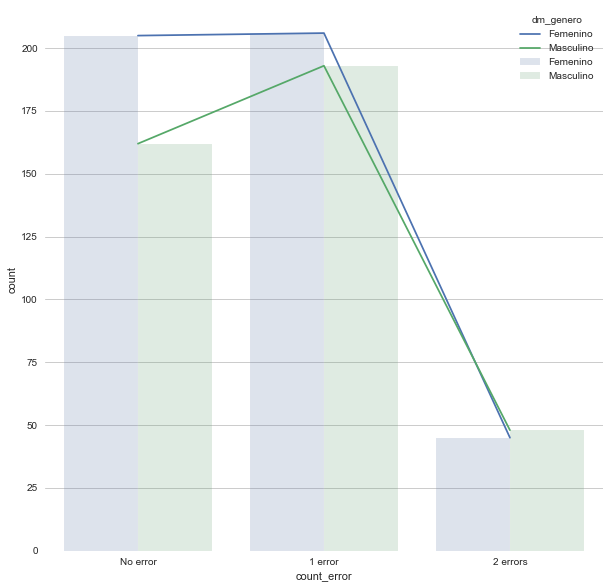

In [65]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [66]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [67]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=1.3152295278596062, pvalue=0.2514499992068521)

### Post-hoc: Dunn test

In [68]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Femenino,Masculino
Femenino,1.000000,0.130334
Masculino,0.130334,1.000000


## Difference due to Uni - None Uni

In [69]:
col_var = 'recode_education'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_education,,,
No university studies,145,206,47
University studies,221,193,46


In [70]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 858


In [71]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_education,,,
No university studies,0.364322,0.517588,0.11809
University studies,0.480435,0.419565,0.10000


### Heatmap

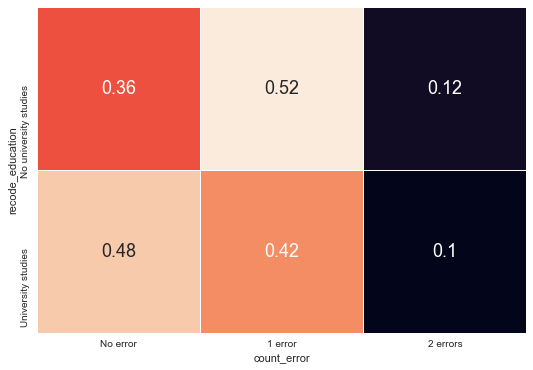

In [72]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [73]:
data_bar_plot = df[['count_error', col_var]].value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,count_error,recode_education,count
0,No error,University studies,221
1,1 error,No university studies,206
2,1 error,University studies,193
3,No error,No university studies,145
4,2 errors,No university studies,47
5,2 errors,University studies,46


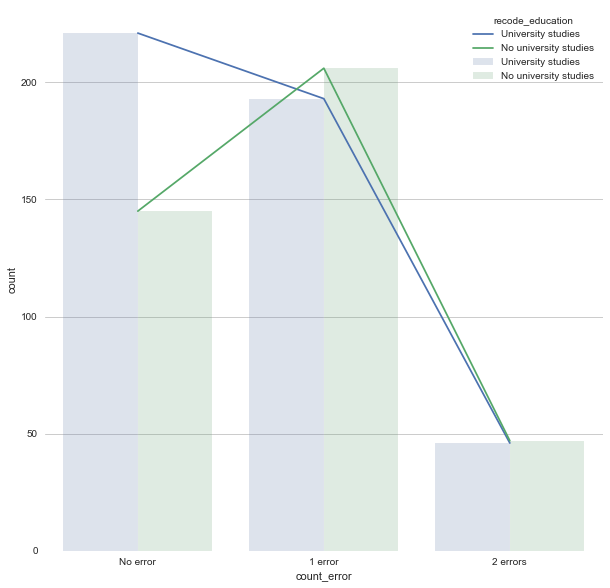

In [74]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [75]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [76]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=10.910010837261137, pvalue=0.000956459660105906)

### Post-hoc: Dunn test

In [77]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,No university studies,University studies
No university studies,1.000000,0.001475
University studies,0.001475,1.000000


## Difference due to edu level

In [78]:
col_var = 'recode_education2'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_education2,,,
up_to_bac_3,83,125,32
up_to_secondaria,62,81,15
up_to_university_level,221,193,46


In [79]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 858


In [80]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_education2,,,
up_to_bac_3,0.345833,0.520833,0.133333
up_to_secondaria,0.392405,0.512658,0.094937
up_to_university_level,0.480435,0.419565,0.100000


### Heatmap

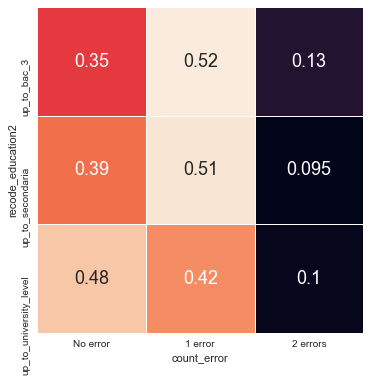

In [81]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [82]:
data_bar_plot = df[['count_error', col_var]].value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,count_error,recode_education2,count
0,No error,up_to_university_level,221
1,1 error,up_to_university_level,193
2,1 error,up_to_bac_3,125
3,No error,up_to_bac_3,83
4,1 error,up_to_secondaria,81
5,No error,up_to_secondaria,62
6,2 errors,up_to_university_level,46
7,2 errors,up_to_bac_3,32
8,2 errors,up_to_secondaria,15


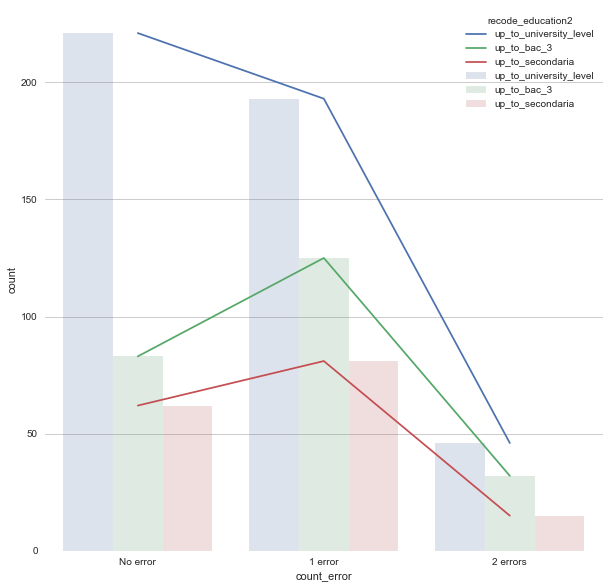

In [83]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [84]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [85]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=11.21490252861373, pvalue=0.003670412357238546)

### Post-hoc: Dunn test

In [86]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,up_to_bac_3,up_to_secondaria,up_to_university_level
up_to_bac_3,1.000000,0.707764,0.002523
up_to_secondaria,0.707764,1.000000,0.351760
up_to_university_level,0.002523,0.351760,1.000000


## Difference with the political parties

In [87]:
col_var = 'recode_politics'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,48,76,13
Derecha,63,80,25
Izquierda,176,144,40


In [88]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 665


In [89]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,0.350365,0.554745,0.094891
Derecha,0.375000,0.476190,0.148810
Izquierda,0.488889,0.400000,0.111111


### Heatmap

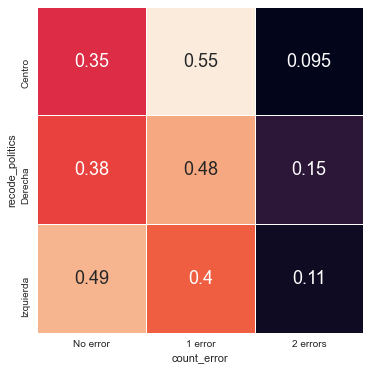

In [90]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [91]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,count_error,count
0,Izquierda,No error,176
1,Izquierda,1 error,144
2,Derecha,1 error,80
3,Centro,1 error,76
4,Derecha,No error,63
5,Centro,No error,48
6,Izquierda,2 errors,40
7,Derecha,2 errors,25
8,Centro,2 errors,13


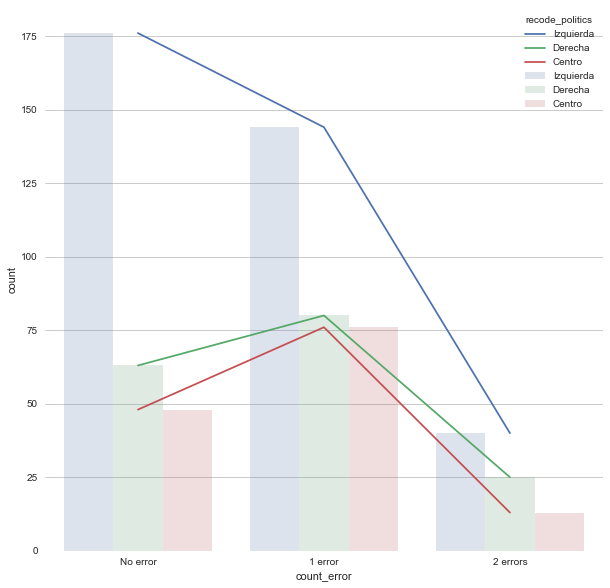

In [92]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [93]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [94]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=11.34863304181378, pvalue=0.003433014568308653)

### Post-hoc: Dunn test

In [95]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Centro,Derecha,Izquierda
Centro,1.000000,1.000000,0.095985
Derecha,1.000000,1.000000,0.038821
Izquierda,0.095985,0.038821,1.000000


## Difference with the religious believes

In [96]:
col_var = 'recode_religion'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_religion,,,
Atheists/Agnostics,172,135,32
Believers,156,223,54


In [97]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 772


In [98]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_religion,,,
Atheists/Agnostics,0.507375,0.398230,0.094395
Believers,0.360277,0.515012,0.124711


### Heatmap

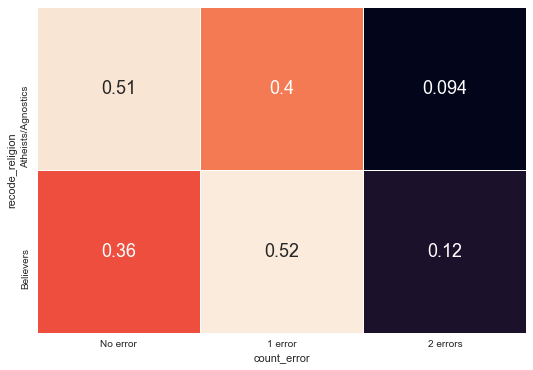

In [99]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [100]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,count_error,count
0,Believers,1 error,223
1,Atheists/Agnostics,No error,172
2,Believers,No error,156
3,Atheists/Agnostics,1 error,135
4,Believers,2 errors,54
5,Atheists/Agnostics,2 errors,32


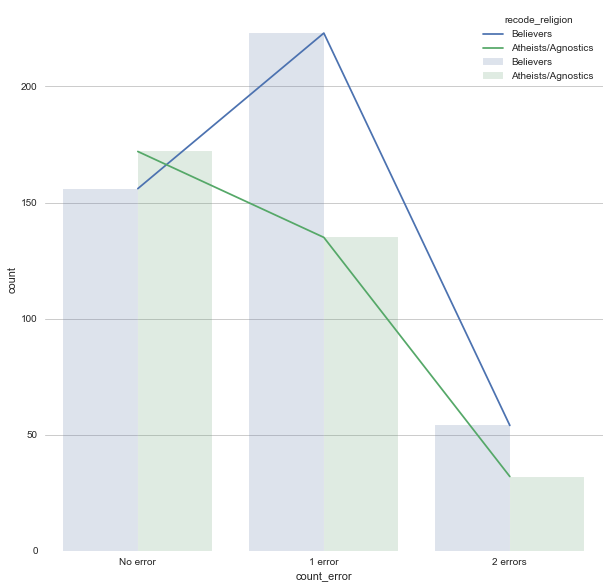

In [101]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [102]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [103]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=14.779004795671312, pvalue=0.00012087380971051312)

### Post-hoc: Dunn test

In [104]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Atheists/Agnostics,Believers
Atheists/Agnostics,1.000000,0.000096
Believers,0.000096,1.000000


## Difference due to level of technology knowledge

In [105]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'count_error']]
# Drop the NS/NC
data= data[data[col_var] != 'NS/NC']
# Drop the na
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,196,175,39
Básica,27,40,9
Media,142,183,45


In [106]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [107]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,0.478049,0.426829,0.095122
Básica,0.355263,0.526316,0.118421
Media,0.383784,0.494595,0.121622


### Heatmap

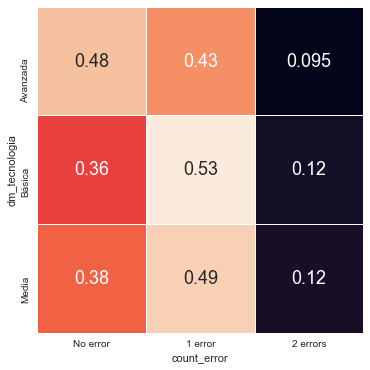

In [108]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [109]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,count_error,count
0,Avanzada,No error,196
1,Media,1 error,183
2,Avanzada,1 error,175
3,Media,No error,142
4,Media,2 errors,45
5,Básica,1 error,40
6,Avanzada,2 errors,39
7,Básica,No error,27
8,Básica,2 errors,9


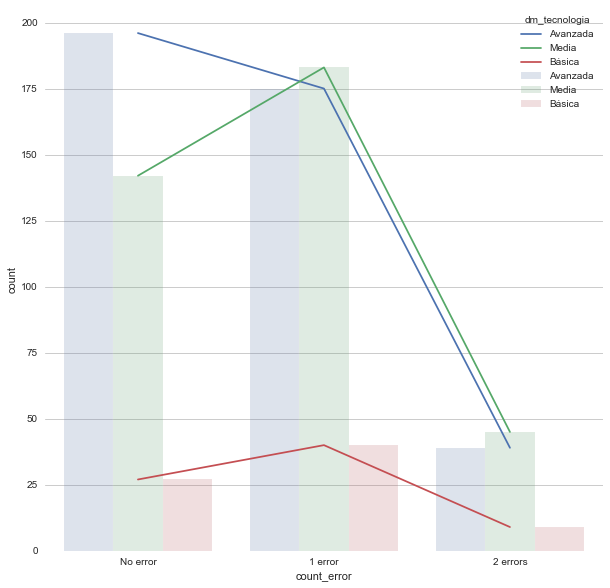

In [110]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [111]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [112]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=7.298091720263974, pvalue=0.026015939785640943)

### Post-hoc: Dunn test

In [113]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Avanzada,Básica,Media
Avanzada,1.000000,0.180719,0.024571
Básica,0.180719,1.000000,1.000000
Media,0.024571,1.000000,1.000000


## Analysis of 4 categories
Here I redo the analysis using the fourth categories created by María del Carmen

In [114]:
variables_to_test = ['recode_age', 'dm_genero','recode_education', 'recode_politics','recode_religion', 'dm_tecnologia']


### Difference with age

In [115]:
col_var = 'recode_age'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
<=18-34,89,60,34,23
35-54,184,105,90,51
>55,94,51,59,19


In [116]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [117]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
<=18-34,0.432039,0.291262,0.165049,0.111650
35-54,0.427907,0.244186,0.209302,0.118605
>55,0.421525,0.228700,0.264574,0.085202


#### Heatmap

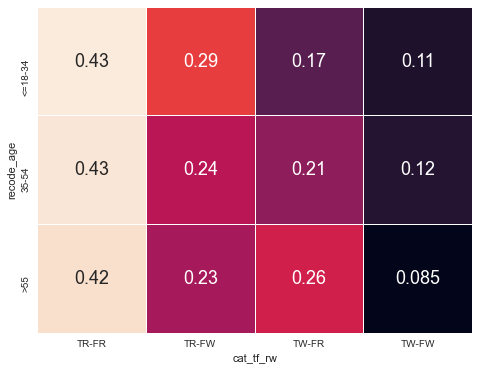

In [118]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [119]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,cat_tf_rw,count
0,35-54,TR-FR,184
1,35-54,TR-FW,105
2,>55,TR-FR,94
3,35-54,TW-FR,90
4,<=18-34,TR-FR,89
5,<=18-34,TR-FW,60
6,>55,TW-FR,59
7,35-54,TW-FW,51
8,>55,TR-FW,51
9,<=18-34,TW-FR,34


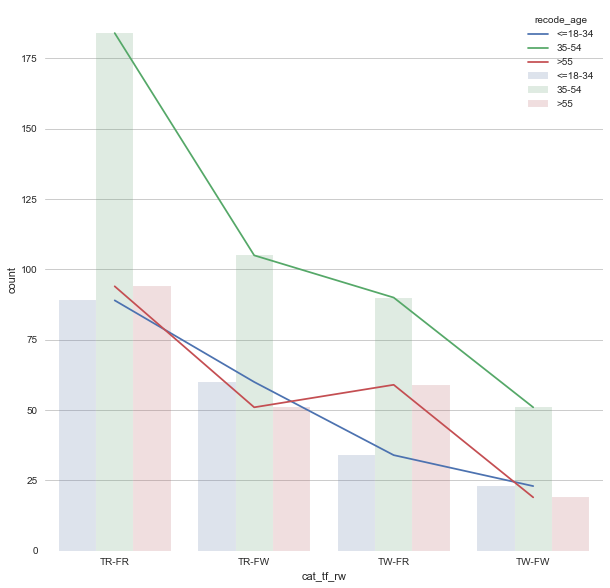

In [120]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [121]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 8.453573758574958, p-value: 0.20671991477672064



,recode_age,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,<=18-34,TR-FR,0.159661,0.873148,1.000000,False,ns
1,<=18-34,TR-FW,1.510405,0.130940,1.000000,False,ns
2,<=18-34,TW-FR,-1.929379,0.053684,0.644206,False,ns
3,<=18-34,TW-FW,0.179340,0.857671,1.000000,False,ns
4,35-54,TR-FR,0.039505,0.968488,1.000000,False,ns
5,35-54,TR-FW,-0.491638,0.622975,1.000000,False,ns
6,35-54,TW-FR,-0.267740,0.788899,1.000000,False,ns
7,35-54,TW-FW,0.976399,0.328867,1.000000,False,ns
8,>55,TR-FR,-0.200546,0.841054,1.000000,False,ns
9,>55,TR-FW,-0.910270,0.362680,1.000000,False,ns


### Difference with gender

In [122]:
col_var = 'dm_genero'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,205,116,90,45
Masculino,162,100,93,48


In [123]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [124]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,0.449561,0.254386,0.197368,0.098684
Masculino,0.401985,0.248139,0.230769,0.119107


#### Heatmap

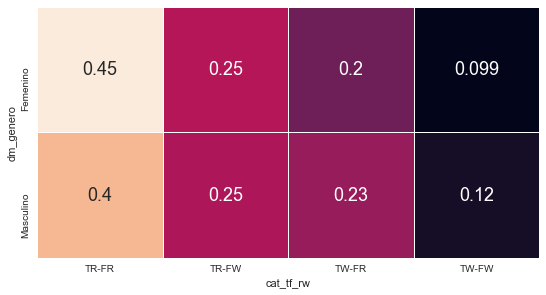

In [125]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [126]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,cat_tf_rw,count
0,Femenino,TR-FR,205
1,Masculino,TR-FR,162
2,Femenino,TR-FW,116
3,Masculino,TR-FW,100
4,Masculino,TW-FR,93
5,Femenino,TW-FR,90
6,Masculino,TW-FW,48
7,Femenino,TW-FW,45


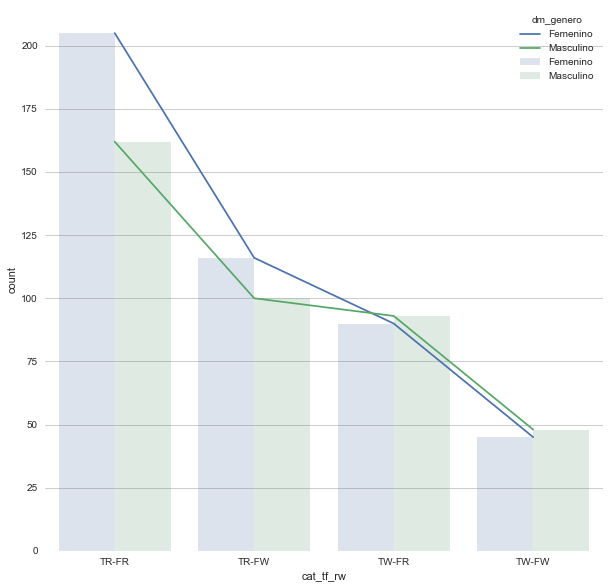

In [127]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [128]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 3.111048641349182, p-value: 0.3748185398656928



,dm_genero,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Femenino,TR-FR,1.406716,0.159512,1.0,False,ns
1,Femenino,TR-FW,0.210606,0.833195,1.0,False,ns
2,Femenino,TW-FR,-1.193135,0.232816,1.0,False,ns
3,Femenino,TW-FW,-0.961356,0.336373,1.0,False,ns
4,Masculino,TR-FR,-1.406716,0.159512,1.0,False,ns
5,Masculino,TR-FW,-0.210606,0.833195,1.0,False,ns
6,Masculino,TW-FR,1.193135,0.232816,1.0,False,ns
7,Masculino,TW-FW,0.961356,0.336373,1.0,False,ns


### Difference with Uni vs Non Uni

In [129]:
col_var = 'recode_education'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No university studies,145,113,93,47
University studies,221,103,90,46


In [130]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [131]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No university studies,0.364322,0.283920,0.233668,0.11809
University studies,0.480435,0.223913,0.195652,0.10000


#### Heatmap

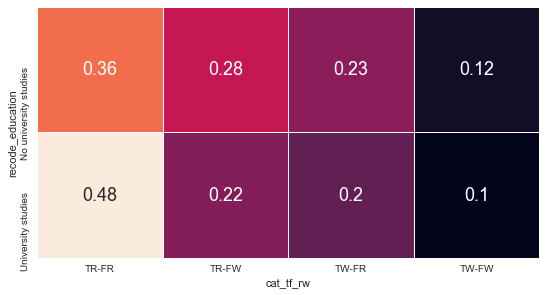

In [132]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [133]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_education,cat_tf_rw,count
0,University studies,TR-FR,221
1,No university studies,TR-FR,145
2,No university studies,TR-FW,113
3,University studies,TR-FW,103
4,No university studies,TW-FR,93
5,University studies,TW-FR,90
6,No university studies,TW-FW,47
7,University studies,TW-FW,46


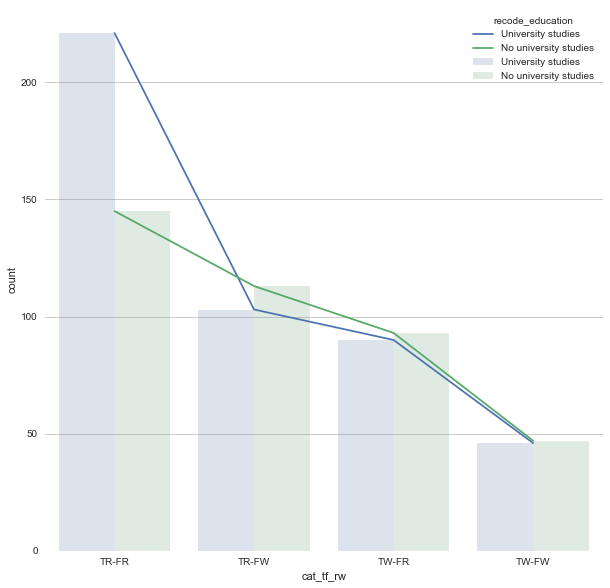

In [134]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [135]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.886195968364882, p-value: 0.007783348266488882



,recode_education,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No university studies,TR-FR,-3.429434,0.000605,0.004839,True,**
1,No university studies,TR-FW,2.019614,0.043423,0.347387,False,ns
2,No university studies,TW-FR,1.355673,0.175203,1.000000,False,ns
3,No university studies,TW-FW,0.850044,0.395301,1.000000,False,ns
4,University studies,TR-FR,3.429434,0.000605,0.004839,True,**
5,University studies,TR-FW,-2.019614,0.043423,0.347387,False,ns
6,University studies,TW-FR,-1.355673,0.175203,1.000000,False,ns
7,University studies,TW-FW,-0.850044,0.395301,1.000000,False,ns


### Difference with political parties

In [136]:
col_var = 'recode_politics'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,48,38,38,13
Derecha,63,48,32,25
Izquierda,176,76,68,40


In [137]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [138]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,0.350365,0.277372,0.277372,0.094891
Derecha,0.375000,0.285714,0.190476,0.148810
Izquierda,0.488889,0.211111,0.188889,0.111111


#### Heatmap

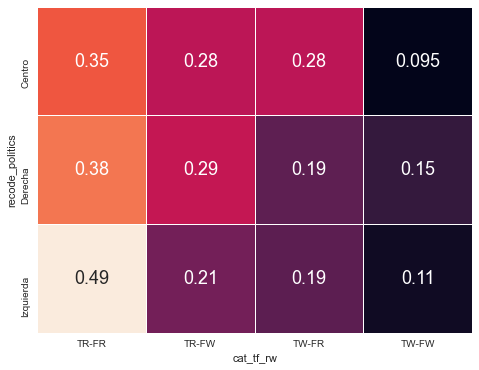

In [139]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [140]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,cat_tf_rw,count
0,Izquierda,TR-FR,176
1,Izquierda,TR-FW,76
2,Izquierda,TW-FR,68
3,Derecha,TR-FR,63
4,Centro,TR-FR,48
5,Derecha,TR-FW,48
6,Izquierda,TW-FW,40
7,Centro,TR-FW,38
8,Centro,TW-FR,38
9,Derecha,TW-FR,32


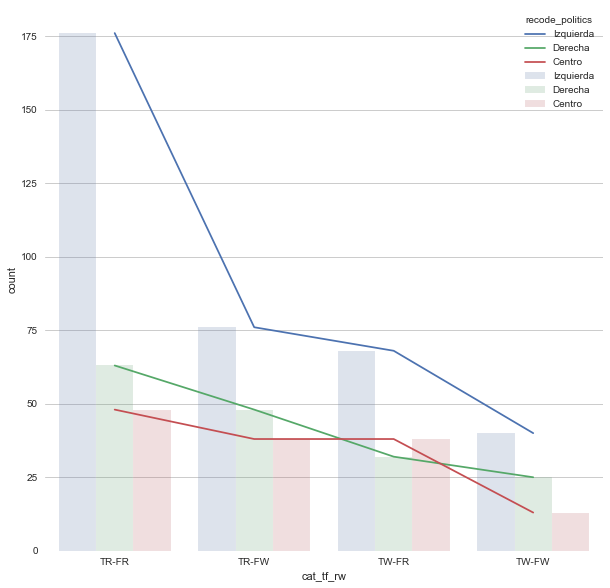

In [141]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [142]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 15.688724720518637, p-value: 0.015525893634485515



,recode_politics,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Centro,TR-FR,-2.153871,0.031250,0.375003,False,ns
1,Centro,TR-FW,1.033186,0.301517,1.000000,False,ns
2,Centro,TW-FR,2.262658,0.023657,0.283881,False,ns
3,Centro,TW-FW,-0.914556,0.360425,1.000000,False,ns
4,Derecha,TR-FR,-1.712683,0.086771,1.000000,False,ns
5,Derecha,TR-FW,1.470631,0.141391,1.000000,False,ns
6,Derecha,TW-FR,-0.630086,0.528638,1.000000,False,ns
7,Derecha,TW-FW,1.468513,0.141965,1.000000,False,ns
8,Izquierda,TR-FR,3.241731,0.001188,0.014257,True,*
9,Izquierda,TR-FW,-2.121035,0.033919,0.407027,False,ns


### Difference with Religious belief

In [143]:
col_var = 'recode_religion'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])

data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
Atheists/Agnostics,172,80,55,32
Believers,156,117,106,54


In [144]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [145]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
Atheists/Agnostics,0.507375,0.235988,0.162242,0.094395
Believers,0.360277,0.270208,0.244804,0.124711


#### Heatmap

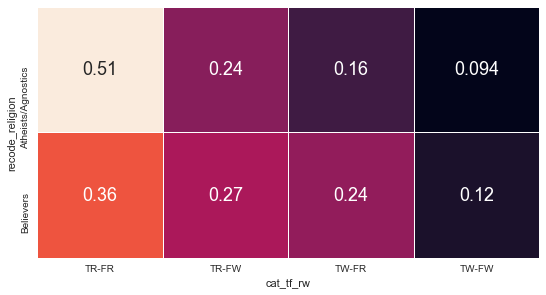

In [146]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [147]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,cat_tf_rw,count
0,Atheists/Agnostics,TR-FR,172
1,Believers,TR-FR,156
2,Believers,TR-FW,117
3,Believers,TW-FR,106
4,Atheists/Agnostics,TR-FW,80
5,Atheists/Agnostics,TW-FR,55
6,Believers,TW-FW,54
7,Atheists/Agnostics,TW-FW,32


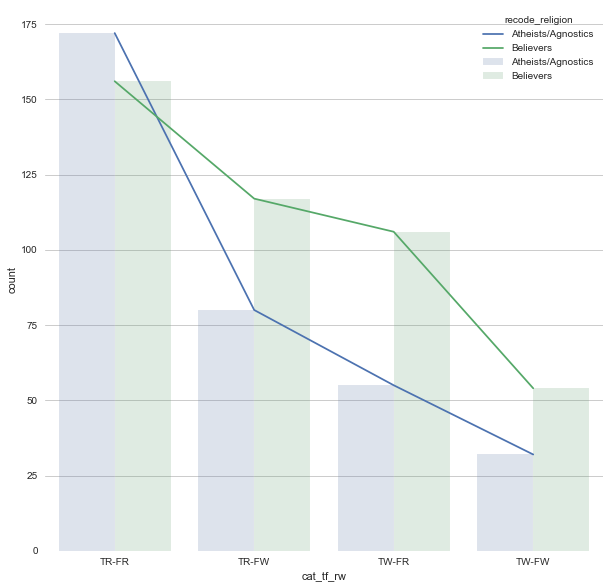

In [148]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [149]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 18.339212362105243, p-value: 0.0003743805774755582



,recode_religion,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Atheists/Agnostics,TR-FR,4.103263,0.000041,0.000326,True,***
1,Atheists/Agnostics,TR-FW,-1.082333,0.279104,1.000000,False,ns
2,Atheists/Agnostics,TW-FR,-2.802193,0.005076,0.040605,True,*
3,Atheists/Agnostics,TW-FW,-1.328659,0.183960,1.000000,False,ns
4,Believers,TR-FR,-4.103263,0.000041,0.000326,True,***
5,Believers,TR-FW,1.082333,0.279104,1.000000,False,ns
6,Believers,TW-FR,2.802193,0.005076,0.040605,True,*
7,Believers,TW-FW,1.328659,0.183960,1.000000,False,ns


### Difference with technological knowledge

In [150]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var],  data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,196,99,76,39
Básica,27,17,23,9
Media,142,100,83,45


In [151]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [152]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,0.478049,0.241463,0.185366,0.095122
Básica,0.355263,0.223684,0.302632,0.118421
Media,0.383784,0.270270,0.224324,0.121622


#### Heatmap

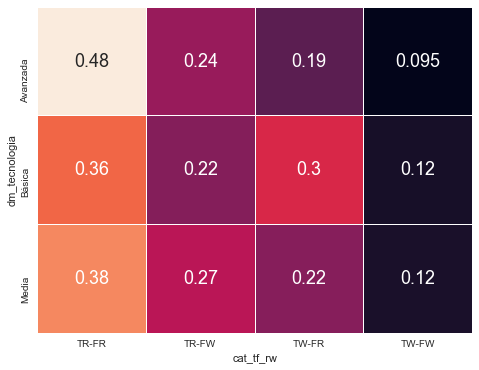

In [153]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [154]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,cat_tf_rw,count
0,Avanzada,TR-FR,196
1,Media,TR-FR,142
2,Media,TR-FW,100
3,Avanzada,TR-FW,99
4,Media,TW-FR,83
5,Avanzada,TW-FR,76
6,Media,TW-FW,45
7,Avanzada,TW-FW,39
8,Básica,TR-FR,27
9,Básica,TW-FR,23


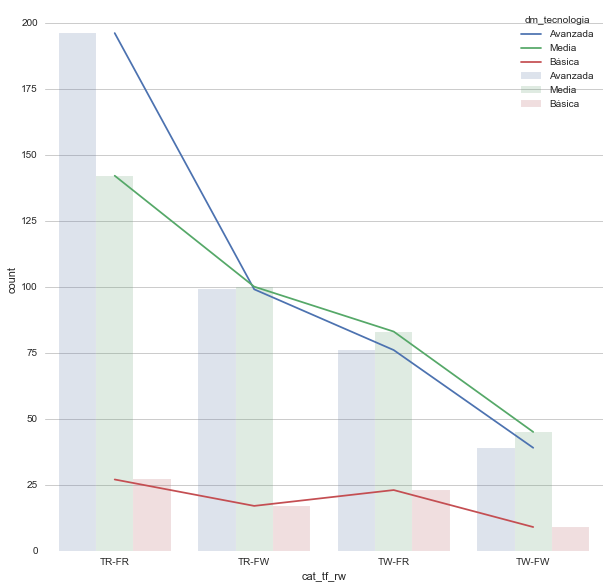

In [155]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [156]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.851089969249614, p-value: 0.06537445362063155



,dm_tecnologia,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Avanzada,TR-FR,2.929492,0.003395,0.040742,True,*
1,Avanzada,TR-FW,-0.702213,0.482546,1.000000,False,ns
2,Avanzada,TW-FR,-1.868321,0.061717,0.740608,False,ns
3,Avanzada,TW-FW,-1.218994,0.222847,1.000000,False,ns
4,Básica,TR-FR,-1.313678,0.188955,1.000000,False,ns
5,Básica,TR-FW,-0.602437,0.546883,1.000000,False,ns
6,Básica,TW-FR,2.009177,0.044518,0.534220,False,ns
7,Básica,TW-FW,0.286904,0.774186,1.000000,False,ns
8,Media,TR-FR,-2.199886,0.027815,0.333780,False,ns
9,Media,TR-FW,1.054021,0.291873,1.000000,False,ns


## Analysis using Right-Wrong distinction

In [157]:
dep_var = 'R-W'

### Difference with age

In [158]:
col_var = 'recode_age'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

R-W,R,W
recode_age,,
<=18-34,89,117
35-54,184,246
>55,94,129


In [159]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [160]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
recode_age,,
<=18-34,0.432039,0.567961
35-54,0.427907,0.572093
>55,0.421525,0.578475


#### Heatmap

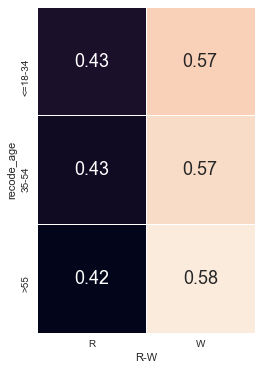

In [161]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [162]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,R-W,count
0,35-54,W,246
1,35-54,R,184
2,>55,W,129
3,<=18-34,W,117
4,>55,R,94
5,<=18-34,R,89


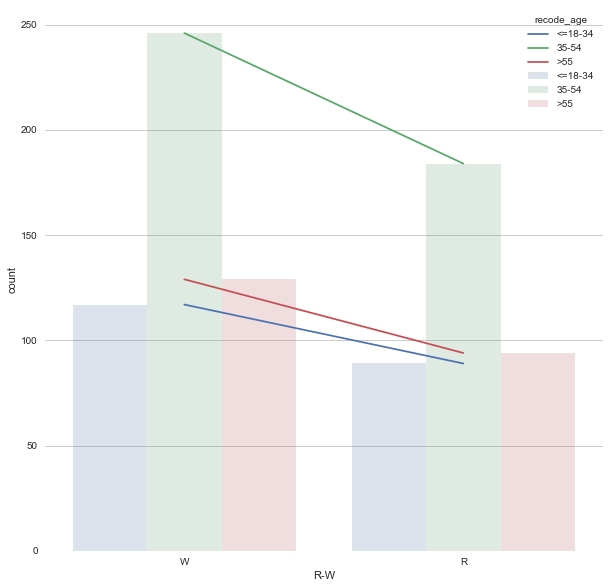

In [163]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [164]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 0.04993554964597885, p-value: 0.9753413420693046



,recode_age,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,<=18-34,R,0.159661,0.873148,1.0,False,ns
1,<=18-34,W,-0.159661,0.873148,1.0,False,ns
2,35-54,R,0.039505,0.968488,1.0,False,ns
3,35-54,W,-0.039505,0.968488,1.0,False,ns
4,>55,R,-0.200546,0.841054,1.0,False,ns
5,>55,W,0.200546,0.841054,1.0,False,ns


### Difference with gender

In [165]:
col_var = 'dm_genero'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

R-W,R,W
dm_genero,,
Femenino,205,251
Masculino,162,241


In [166]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [167]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
dm_genero,,
Femenino,0.449561,0.550439
Masculino,0.401985,0.598015


#### Heatmap

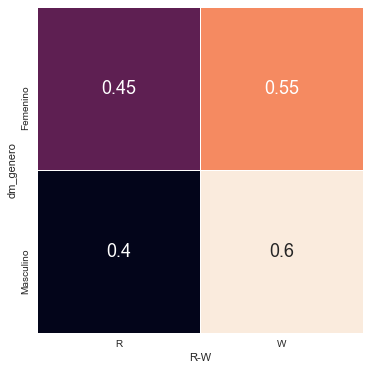

In [168]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [169]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,R-W,count
0,Femenino,W,251
1,Masculino,W,241
2,Femenino,R,205
3,Masculino,R,162


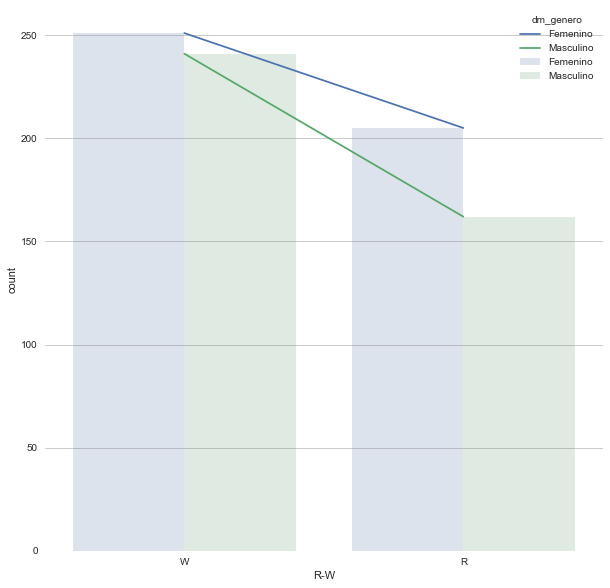

In [170]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [171]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 1.7892042052701642, p-value: 0.1810231526560922



,dm_genero,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Femenino,R,1.406716,0.159512,0.638046,False,ns
1,Femenino,W,-1.406716,0.159512,0.638046,False,ns
2,Masculino,R,-1.406716,0.159512,0.638046,False,ns
3,Masculino,W,1.406716,0.159512,0.638046,False,ns


### Difference with Uni vs Non Uni

In [172]:
col_var = 'recode_education'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

R-W,R,W
recode_education,,
No university studies,145,253
University studies,221,239


In [173]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [174]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
recode_education,,
No university studies,0.364322,0.635678
University studies,0.480435,0.519565


#### Heatmap

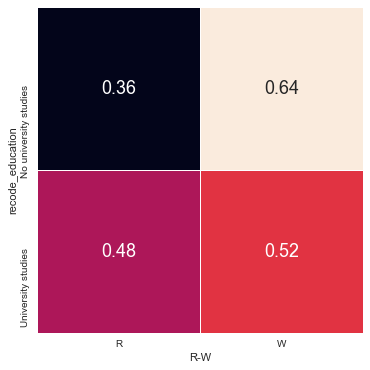

In [175]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [176]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_education,R-W,count
0,No university studies,W,253
1,University studies,W,239
2,University studies,R,221
3,No university studies,R,145


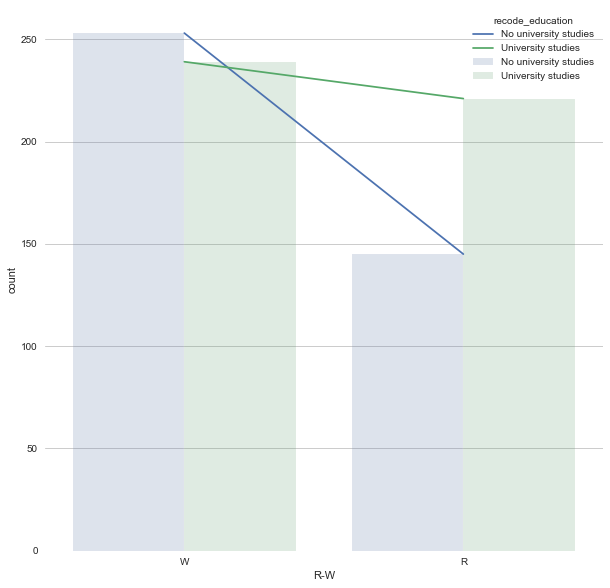

In [177]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [178]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.29112033414732, p-value: 0.0007787867192997264



,recode_education,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No university studies,R,-3.429434,0.000605,0.002419,True,**
1,No university studies,W,3.429434,0.000605,0.002419,True,**
2,University studies,R,3.429434,0.000605,0.002419,True,**
3,University studies,W,-3.429434,0.000605,0.002419,True,**


### Difference with political parties

In [179]:
col_var = 'recode_politics'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

R-W,R,W
recode_politics,,
Centro,48,89
Derecha,63,105
Izquierda,176,184


In [180]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [181]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
recode_politics,,
Centro,0.350365,0.649635
Derecha,0.375000,0.625000
Izquierda,0.488889,0.511111


#### Heatmap

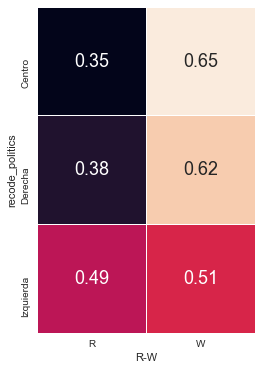

In [182]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [183]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,R-W,count
0,Izquierda,W,184
1,Izquierda,R,176
2,Derecha,W,105
3,Centro,W,89
4,Derecha,R,63
5,Centro,R,48


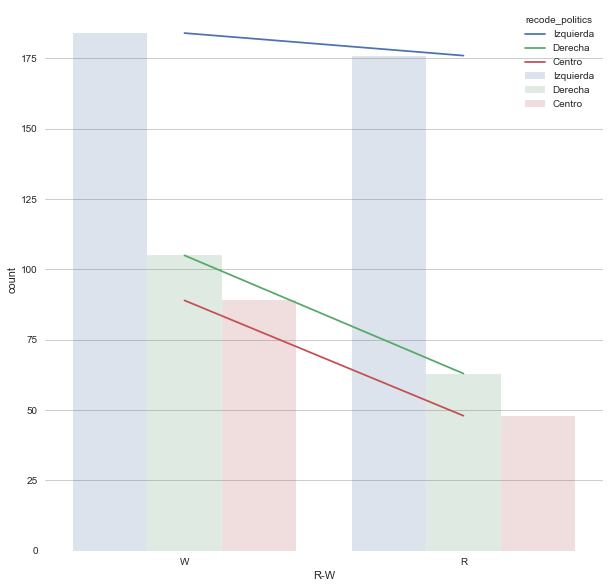

In [184]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [185]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 10.69550058757548, p-value: 0.004758844968845993



,recode_politics,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Centro,R,-2.153871,0.031250,0.187502,False,ns
1,Centro,W,2.153871,0.031250,0.187502,False,ns
2,Derecha,R,-1.712683,0.086771,0.520625,False,ns
3,Derecha,W,1.712683,0.086771,0.520625,False,ns
4,Izquierda,R,3.241731,0.001188,0.007128,True,**
5,Izquierda,W,-3.241731,0.001188,0.007128,True,**


### Difference with Religious belief

In [186]:
col_var = 'recode_religion'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count2 = pd.crosstab( data[dep_var], data[col_var])

data_count

R-W,R,W
recode_religion,,
Atheists/Agnostics,172,167
Believers,156,277


In [187]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [188]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
recode_religion,,
Atheists/Agnostics,0.507375,0.492625
Believers,0.360277,0.639723


#### Heatmap

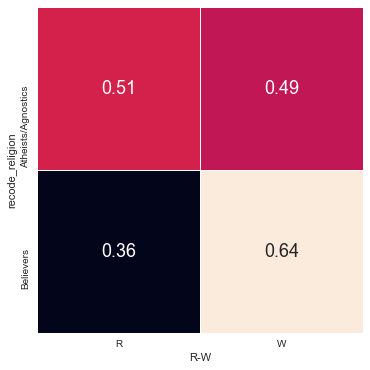

In [189]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [190]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,R-W,count
0,Believers,W,277
1,Atheists/Agnostics,R,172
2,Atheists/Agnostics,W,167
3,Believers,R,156


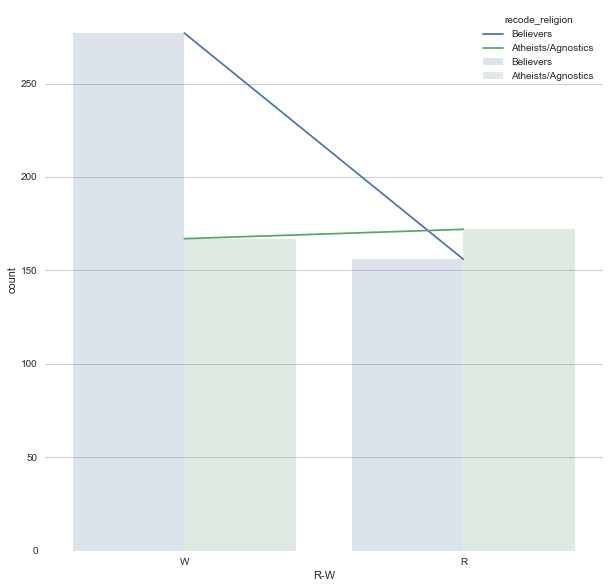

In [191]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [192]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 16.240163830976343, p-value: 5.5798529961421525e-05



,recode_religion,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Atheists/Agnostics,R,4.103263,0.000041,0.000163,True,***
1,Atheists/Agnostics,W,-4.103263,0.000041,0.000163,True,***
2,Believers,R,-4.103263,0.000041,0.000163,True,***
3,Believers,W,4.103263,0.000041,0.000163,True,***


### Difference with technological knowledge

In [193]:
col_var = 'dm_tecnologia'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var],  data[dep_var])
data_count2 = pd.crosstab( data[dep_var], data[col_var])
data_count

R-W,R,W
dm_tecnologia,,
Avanzada,196,214
Básica,27,49
Media,142,228


In [194]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [195]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

R-W,R,W
dm_tecnologia,,
Avanzada,0.478049,0.521951
Básica,0.355263,0.644737
Media,0.383784,0.616216


#### Heatmap

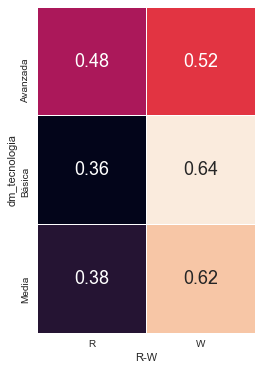

In [196]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [197]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,R-W,count
0,Media,W,228
1,Avanzada,W,214
2,Avanzada,R,196
3,Media,R,142
4,Básica,W,49
5,Básica,R,27


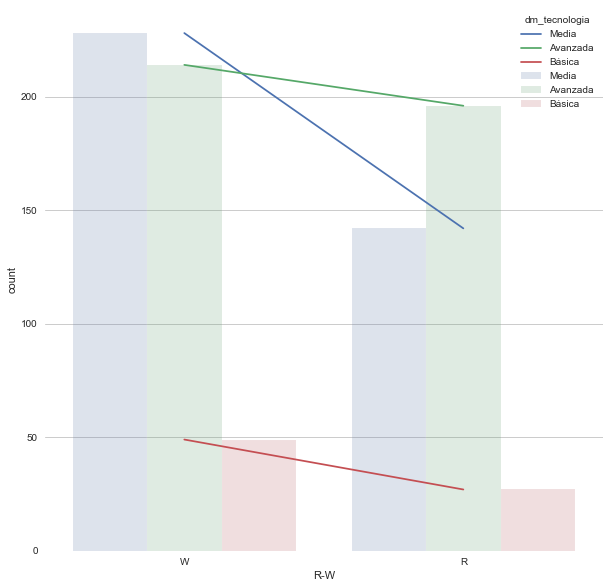

In [198]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [199]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 8.791610710945442, p-value: 0.01232894714104229



,dm_tecnologia,R-W,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Avanzada,R,2.929492,0.003395,0.020371,True,*
1,Avanzada,W,-2.929492,0.003395,0.020371,True,*
2,Básica,R,-1.313678,0.188955,1.000000,False,ns
3,Básica,W,1.313678,0.188955,1.000000,False,ns
4,Media,R,-2.199886,0.027815,0.166890,False,ns
5,Media,W,2.199886,0.027815,0.166890,False,ns


## Analysis of actions

TODO

In [200]:
# Does the people that are wrong, will more often share news with their family than people that are right
# Does fake news will be more often shared than true news. 
var_actions_f = ['faf_compartira_familia_amigos']
var_actions_t = ['taf_compartira_familia_amigos']
var_actions = var_actions_f + var_actions_t

data = df[['True news', 'Fake news', *var_actions]]
data = data.melt(id_vars=[*var_actions])
data = data.rename(columns={'variable': 'type_news', 'value': 'answer'})
data = data[data['answer'] == 'Wrong']

# References

## Packages

 * mord: [https://github.com/fabianp/mord](https://github.com/fabianp/mord)
     >Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * pingouin: [https://pingouin-stats.org/](https://pingouin-stats.org/)
     > Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org](https://www.statsmodels.org)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * scipy: [https://www.scipy.org](https://www.scipy.org)
     > @ARTICLE{2020SciPy-NMeth, author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and Haberland, Matt and Reddy, Tyler and Cournapeau, David and Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and Bright, Jonathan and {van der Walt}, St{\'e}fan J. and Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and Kern, Robert and Larson, Eric and Carey, C J and Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and Harris, Charles R. and Archibald, Anne M. and Ribeiro, Ant{\^o}nio H. and Pedregosa, Fabian and {van Mulbregt}, Paul and {SciPy 1.0 Contributors}},title   = {{{SciPy} 1.0: Fundamental Algorithms for Scientific Computing in Python}}, journal = {Nature Methods}, year    = {2020}, volume  = {17}, pages   = {261--272}, adsurl  = {https://rdcu.be/b08Wh}, doi     = {10.1038/s41592-019-0686-2},}
 * scikit-learn: [https://scikit-learn.org](https://scikit-learn.org)
     > Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199